### Features vs. TSS neighborhoods
*Purpose*: investigate the number of features around up/down/nonsig genes for dNipbl 24h. Uses histograms

In [1]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import bioframe
import filter_gene_functions as flt
from plotting_heatmap_functions import format_ticks

save_plots = False
DE_possibilities = ['down', 'up', 'nonsig']
de_color_dict ={ "up": 'tab:red', 
                 "down": 'tab:blue', 
                 "nonsig": 'tab:gray'}

In [2]:
chip_dir = ('/project/fudenber_735/collaborations/karissa_2022/'+
            '2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/')
bed_dict = {
    'H3K27Ac':chip_dir+'H3K27ac_EA92-97_peaks.xls.bed',
    'CTCF':   chip_dir+'CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed',
    'Nipbl':   chip_dir+'Nipbl_112.175.197.114.177.196_peaks.xls.bed',
    'Rad21':  chip_dir+'RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed'
}

dataset_folder = '/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/Published_datasets/'
chen_s1 = 'Enhancers_Chen2012_S1_remapped_mm10.bed'
whythe_super = 'Super-enhancers_mESCs_(OSN-MED1)_Wythe-Cell-2023_mm10-lifetover.bed'
enhancer_dict = {'enh_chen_s1' : dataset_folder+chen_s1,
                 'enh_wythe_super' : dataset_folder+whythe_super}
bed_dict = {**bed_dict, **enhancer_dict}



In [3]:
proj = ("/project/fudenber_735/collaborations/karissa_2022/"+
        "20220812_EA18-1_RNAseq-Analysis_forGeoff/")

# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

# Sample count data for the non-significant results
normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv'
vst_normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv'
feature_counts = '20220816_featureCounts.csv'

WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']
day1_res_df = pd.read_csv(proj+day1_sigRes)

In [4]:
# import table of raw feature counts and calculate average
feat_counts_df = pd.read_csv(proj+feature_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
feat_counts_df['avg'] = feat_counts_df[WT_samples].mean(axis='columns')
print('raw feature counts shape: ', str(feat_counts_df.shape))

# import table of normalized feature counts and calculate average
vst_counts_df = pd.read_csv(proj+vst_normalized_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
vst_counts_df['avg'] = vst_counts_df[WT_samples].mean(axis='columns')
print('vst normalized feature counts shape: ', str(vst_counts_df.shape))

feat_counts_df = feat_counts_df.merge(vst_counts_df, on='Geneid', how='left', suffixes=('_counts', '_vst_counts'))
feat_counts_df['avg_vst_counts'].fillna(feat_counts_df['avg_counts'], inplace=True)

print(feat_counts_df.shape)
print(feat_counts_df['avg_vst_counts'].isna().sum())

# add average normalized counts value to results df
day1_res_df = day1_res_df.merge(feat_counts_df[['Geneid', 'avg_vst_counts', 'avg_counts']], on='Geneid', how='outer')
df = day1_res_df.copy()

raw feature counts shape:  (55421, 110)
vst normalized feature counts shape:  (36446, 14)
(55421, 123)
0


In [12]:
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/"+
      "old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
tss_intervals = flt.get_tss_gene_intervals(tss_df)
tss_intervals['tss'] = tss_intervals['start'].copy()

### create df with intervals & expression data
tss_df = tss_intervals.merge(df.copy(),  how='left',
            left_on='gene_id', right_on='Geneid')
tss_df = flt.label_DE_status(tss_df)
tss_df = tss_df.query("  avg_counts > 5").copy()

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [13]:
def extract_features_around_TSS(tss_df, feature_df, window_size=int(1e6)):

    tss_feature_df = bioframe.overlap(
        bioframe.expand(tss_df, pad= window_size),
        feature_df,
        how = 'left'
    )
    mids = .5*(tss_feature_df['start_']+tss_feature_df['end_']).values 
    dists = np.abs( (mids- tss_feature_df['tss'].values))
    tss_feature_df['dist'] = dists
    
    return tss_feature_df


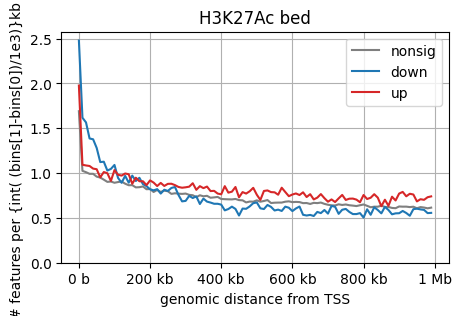

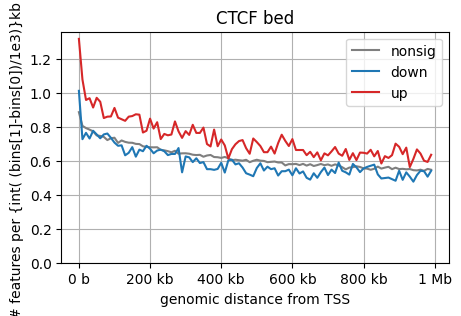

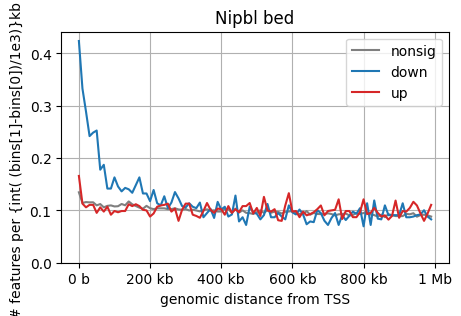

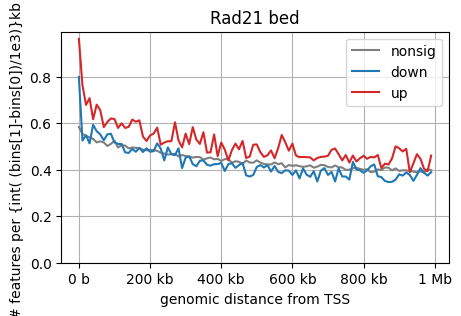

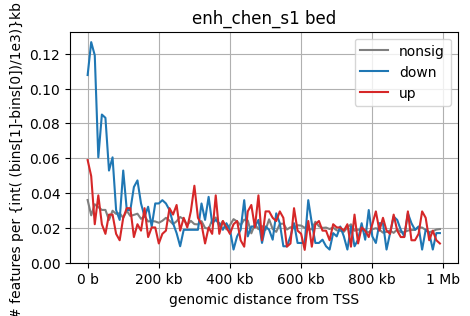

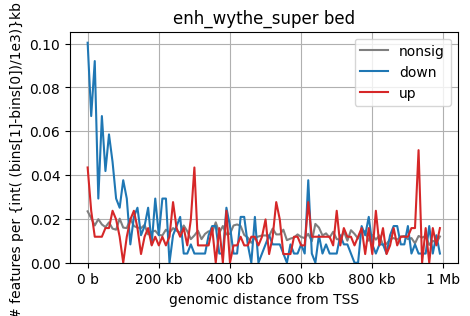

In [14]:
# plot of the number of elements
# in a bed file around each TSS 
# (normalzied by the number of genes in a given category)

window_size = int( 1e6)
bins = np.linspace(0, window_size, 101)
figsize = (5,3)

for bed_name, bed_path in bed_dict.items():
    
    if not 'enh' in bed_name:
        feature_df = bioframe.read_table(bed_path, schema='bed')
    else:
        feature_df = bioframe.read_table(bed_path, schema='bed3', header=1)
    
    plt.figure(figsize=figsize)
    
    tss_vs_feature_df = extract_features_around_TSS(tss_df, feature_df, window_size=window_size)

    for DE_status in ['nonsig', 'down', 'up']:
        de_vs_features = tss_vs_feature_df.iloc[ tss_vs_feature_df['DE_status'].values==DE_status].copy()
        de_vs_features.dropna(subset=[ 'dist'], inplace=True)
        num_genes_in_category = de_vs_features['gene_id'].unique().shape[0] 

        a,b = np.histogram( 
                de_vs_features['dist'],
                bins=bins);

        plt.plot( bins[:-1], 
                  a/num_genes_in_category,
                  label=DE_status, 
                  color = de_color_dict[DE_status])
    ax = plt.gca()
    format_ticks(ax)
    plt.ylabel('# features per {int( (bins[1]-bins[0])/1e3)}kb bin')
    plt.xlabel('genomic distance from TSS')
    plt.title(bed_name + ' bed', fontsize=12)
    plt.legend()
    plt.grid()
    plt.ylim([0, ax.get_ylim()[1]] )
    if save_plots: 
        plt.savefig(f'./figs/{bed_name}_features_per_10kb-bin.png')
    plt.show()

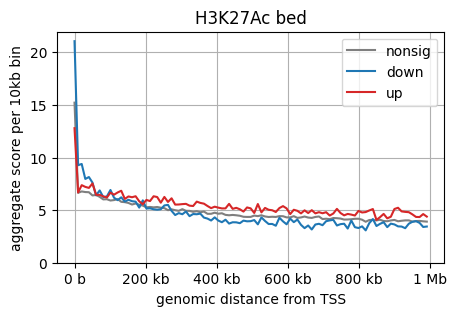

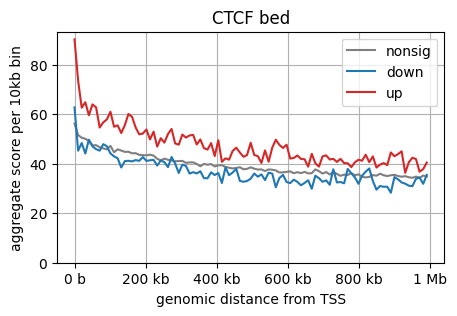

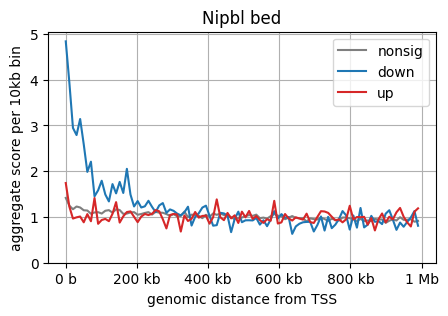

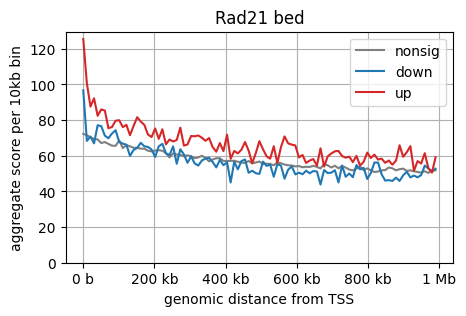

In [16]:
# plot of the number of elements, weighted by their score
# in a bed file around each TSS 
# (normalzied by the number of genes in a given category)

window_size = int( 1e6)
bins = np.linspace(0, window_size, 100)

for bed_name, bed_path in bed_dict.items():
    
    if not 'enh' in bed_name:
        feature_df = bioframe.read_table(bed_path, schema='bed')
    else:
        continue
    
    if not 'score' in feature_df.keys():
        raise KeyError("need to have a bed file with score column for weighted histogram")
    
    plt.figure(figsize=figsize)
    
    tss_vs_feature_df = extract_features_around_TSS(tss_df, feature_df, window_size=window_size)

    for DE_status in ['nonsig', 'down', 'up']:
        de_vs_features = tss_vs_feature_df.iloc[ tss_vs_feature_df['DE_status'].values==DE_status].copy()
        de_vs_features.dropna(subset=[ 'dist'], inplace=True)
        num_genes_in_category = de_vs_features['gene_id'].unique().shape[0] 

        a,b = np.histogram( 
                de_vs_features['dist'],
                weights=de_vs_features['score_'],
                bins=bins);

        plt.plot( bins[:-1], 
                  a/num_genes_in_category,
                  label=DE_status, 
                  color = de_color_dict[DE_status])
    ax = plt.gca()
    format_ticks(ax)
    plt.ylabel('aggregate score per 10kb bin')
    plt.xlabel('genomic distance from TSS')
    plt.title(bed_name + ' bed', fontsize=12)
    plt.legend()
    plt.grid()
    
    plt.ylim([0, ax.get_ylim()[1]] )
    if save_plots: plt.savefig(bed_name+'_score-weighted_features_per_bin.png')
    plt.show()